In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import torch
torch.manual_seed(12345)
from torch import nn
import dsntnn
from trainer import *
from dsntnn import *
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# from networks import ResNet50

In [99]:
class ResNet50_up(nn.Module):
    def __init__(self):
        super(ResNet50_up, self).__init__()
        resnet_50_s = torchvision.models.resnet50(pretrained=True)
        resnet_layer = nn.Sequential(*list(resnet_50_s.children())[:-2])
        self.resnet = resnet_layer
        # print(self.resnet)
        self.uplayers1 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
        )
        self.uplayers2 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
        )
            
        
    def forward(self, x):
        x = self.resnet(x)
        x=self.uplayers1(x)
        x=self.uplayers2(x)
#         x=self.avgpool(x)
#         x = x.view(x.size(0), -1)
        # print(x.shape)
#         x = self.fc(x)
        return x
    def get_embedding(self, x):
        return self.forward(x)

In [100]:
class CoordRegressionNetwork(nn.Module):
    def __init__(self, n_locations):
        super().__init__()
        self.fcn = ResNet50_up()
        self.hm_conv = nn.Conv2d(64, n_locations, kernel_size=1, bias=False)

    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # 3. Normalize the heatmaps
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        # 4. Calculate the coordinates
        coords = dsntnn.dsnt(heatmaps)

        return coords, heatmaps

In [101]:
from torch import optim
import matplotlib.pyplot as plt
import scipy.misc

Matplotlib is building the font cache; this may take a moment.


In [190]:
from datasets import TVDataset
from torchvision import transforms
import torch
import numpy as np
import os
from trainer import fit
from torch.optim import lr_scheduler
from utils import ResziePadding
from PIL import Image
import cv2
cuda = torch.cuda.is_available()

In [191]:
root_dir='./data/tv'
transform_step=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])
train_dataset = TVDataset(root_dir=root_dir,transform=transform_step,imgsz=224)
test_dataset = TVDataset(root_dir=root_dir,transform=transform_step,imgsz=224,is_train=False)
batch_size=32
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [192]:
embedding_model=ResNet50_up().cuda()
model = CoordRegressionNetwork(n_locations=8).cuda()
if cuda:
    model.cuda()

In [195]:
euc_loss_fn = Euclidean_losses()
reg_loss_fn = Js_reg_losses()
loss_fn = Average_loss()
lr = 2.5e-4
sigma_t=torch.Tensor([1.0]).cuda()
optimizer = optim.RMSprop(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 200
log_interval = 500

In [ ]:
fit(train_loader, test_loader, model, euc_loss_fn, reg_loss_fn, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
model=torch.load('./models/10-0.25146410507815226.ckpt')
model.eval()

In [250]:
img=os.path.join('./data/tv','images','val','3c480a1d49c8935b725384971fea8802-snap.jpg')
lab=os.path.join('./data/tv','labels','val','3c480a1d49c8935b725384971fea8802-snap.npy')
label=np.load(lab)
img_data=cv2.imread(img)
# print(img_data)
h,w,_ = img_data.shape
label[:,0]=label[:,0]*w
label[:,1]=label[:,1]*h
image_size=torch.Tensor([w,h])
target = (torch.Tensor(label) * 2 + 1) / image_size - 1
img_data=ResziePadding(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB), fixed_side=224)
img = Image.fromarray(img_data, mode='RGB')
img = torch.unsqueeze(transform_step(img), 0)
# print(input_var.shape)
coords, heatmaps = model(img.cuda())
print(coords.shape)
print(heatmaps.shape)
print('Predicted coords: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
print('GT coords: {:0.4f}, {:0.4f}'.format(*list(target[6])))
# plt.imshow(heatmaps[0, 7].detach().cpu().numpy())
# plt.show()

torch.Size([1, 8, 2])
torch.Size([1, 8, 28, 28])
Predicted coords: -0.5876, 0.1860
GT coords: 0.6036, 0.1509


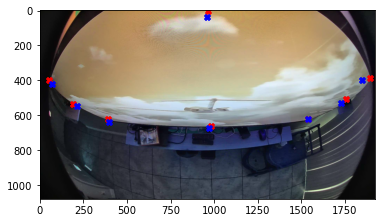

In [251]:
img_data=cv2.imread(os.path.join('./data/tv','images','val','3c480a1d49c8935b725384971fea8802-snap.jpg'))
h,w,_ = img_data.shape
x_gt=((target[:,0]+1)*w-1)/2
y_gt=((target[:,1]+1)*h-1)/2
x_pre=((coords[0,:,0]+1)*w-1)/2
y_pre=((coords[0,:,1]+1)*h-1)/2
plt.imshow(img_data)
plt.scatter(x_gt, y_gt, color='red', marker='X')
plt.scatter(x_pre.cpu().detach().numpy(), y_pre.cpu().detach().numpy(), color='blue', marker='X')
plt.show()